In [1]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import os
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import json

load_dotenv()

PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT")).resolve()  # type: ignore
DATA_ROOT = Path(os.getenv("DATA_ROOT")).resolve()  # type: ignore

In [2]:
win_rate_root = DATA_ROOT / "experiment2" / "validation"
steps: list[list] = []
win_rates: list[list] = []
names = []

for sub in sorted(win_rate_root.iterdir()):
    if not sub.is_dir():
        with open(sub, "r") as f:
            loaded = json.load(f)
            assert isinstance(loaded, list)
        names.append(sub.name[0:-13].replace("_", " "))
        step = []
        win_rate = []
        for item in loaded:
            assert isinstance(item, dict)
            step.append(item["step"])
            win_rate.append(item["win_rate"])
        sorted_pairs = sorted(zip(step, win_rate))
        step, win_rate = zip(*sorted_pairs)
        steps.append(step)
        win_rates.append(win_rate)

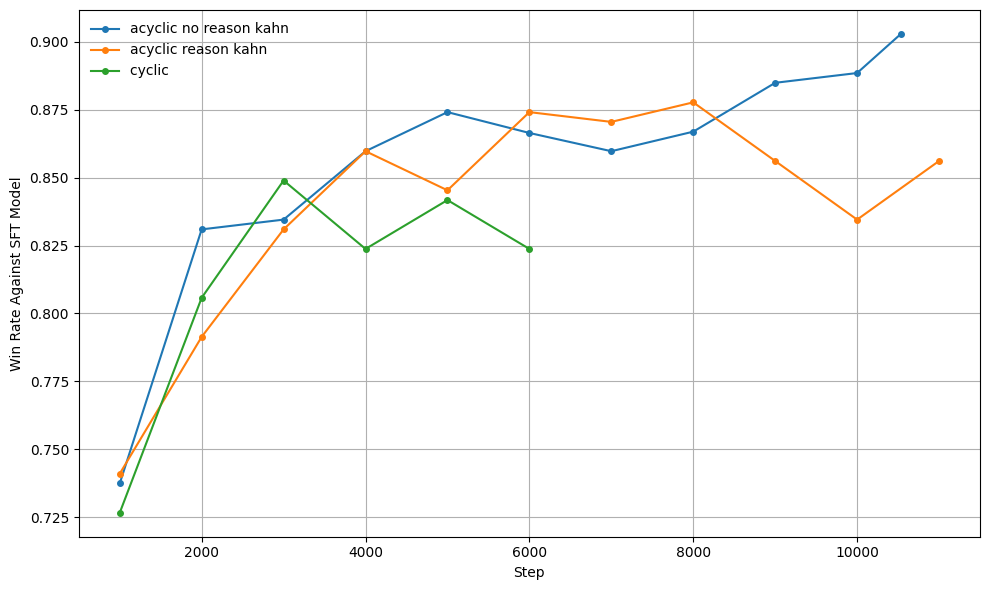

In [4]:
plt.figure(figsize=(10, 6))
for i in range(len(names)):
    plt.plot(steps[i], win_rates[i], label=names[i], marker='o', markersize=4)
plt.xlabel("Step")
plt.ylabel("Win Rate Against SFT Model")
plt.legend(frameon=False)
plt.grid()
plt.tight_layout()
plt.savefig(PROJECT_ROOT / "graphs" / "experiment2"/ "comparisons" / "validation_win_rate.png", dpi=300)